From : https://math.libretexts.org/Bookshelves/Scientific_Computing_Simulations_and_Modeling/Book%3A_Introduction_to_the_Modeling_and_Analysis_of_Complex_Systems_(Sayama)/16%3A_Dynamical_Networks_I__Modeling/16.02%3A_Simulating_Dynamics_on_Networks

In [9]:
import networkx as nx
from random import random
import matplotlib.pyplot as plt

In [14]:
def initialize():
  global g, nextg
  g = nx.karate_club_graph() # Returns Zachary’s Karate Club graph. Each node in the returned graph has a node attribute ‘club’ that indicates the name of the club to which the member represented by that node belongs, either ‘Mr. Hi’ or ‘Officer’. Each edge has a weight based on the number of contexts in which that edge’s incident node members interacted.
  g.pos = nx.spring_layout(g) # Position nodes using Fruchterman-Reingold force-directed algorithm
  for i in g.nodes(): # more memory efficient than g.nodes()
    g.nodes[i]['state'] = 1 if random()<.5 else 0
  nextg = g.copy


def observe():
  global g, nextg
  plt.cla() # claer axis
  nx.draw(g, cmap=plt.cm.binary, vmin=0, vmax=1, node_color = [g.nodes[i]['state'] for i in g.nodes()], pos=g.pos)


def update():
  global g, nextg
  for i in g.nodes():
    count = g.nodes[i]['state']
    for j in g.neighbors(i):
      count += g.nodes[j]['state']
    ratio = count / (g.degree(i) + 1.0)

    if ratio>.5: nextg.nodes[i]['state'] = 1

    elif ratio<.5: nextg.nodes[i]['state'] = 0

    elif random()<.5: nextg.nodes[i]['state'] = 1


  g, nextg = nextg, g



AttributeError: ignored

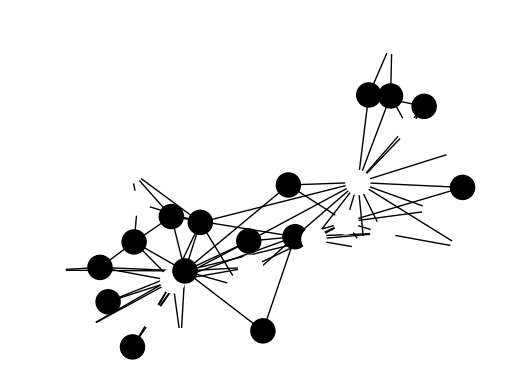

In [15]:
initialize()
observe()
update()

From: https://towardsdatascience.com/schellings-model-of-racial-segregation-4852fad06c13

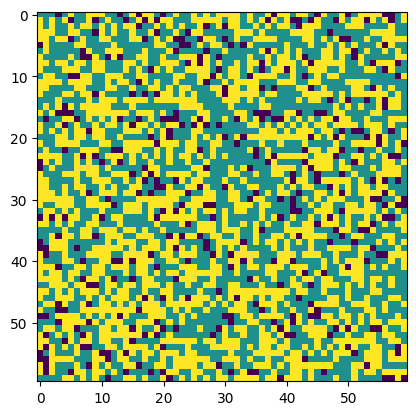

In [21]:
N = 60       # Grid will be N x N
SIM_T = 0.4  # Similarity threshold (that is 1-τ)
EMPTY = 0.1  # Fraction of vacant properties
B_to_R = 1   # Ratio of blue to red people

import numpy as np

def rand_init(N, B_to_R, EMPTY):
    """ Random system initialisation.
    BLUE  =  0
    RED   =  1
    EMPTY = -1
    """
    vacant = int(N * N * EMPTY)
    population = N * N - vacant
    blues = int(population * 1 / (1 + 1/B_to_R))
    reds = population - blues
    M = np.zeros(N*N, dtype=np.int8)
    M[:reds] = 1
    M[-vacant:] = -1
    np.random.shuffle(M)
    return M.reshape(N,N)

KERNEL = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]], dtype=np.int8)

from scipy.signal import convolve2d

def evolve(M, boundary='wrap'):
    """
    Args:
        M (numpy.array): the matrix to be evolved
        boundary (str): Either wrap, fill, or symm
    If the similarity ratio of neighbours
    to the entire neighborhood population
    is lower than the SIM_T,
    then the individual moves to an empty house.
    """
    kws = dict(mode='same', boundary=boundary)
    b_neighs = convolve2d(M == 0, KERNEL, **kws)
    r_neighs = convolve2d(M == 1, KERNEL, **kws)
    neighs   = convolve2d(M != -1,  KERNEL, **kws)

    b_dissatified = (b_neighs / neighs < SIM_T) & (M == 0)
    r_dissatified = (r_neighs / neighs < SIM_T) & (M == 1)
    M[r_dissatified | b_dissatified] = - 1
    vacant = (M == -1).sum()

    n_b_dissatified, n_r_dissatified = b_dissatified.sum(), r_dissatified.sum()
    filling = -np.ones(vacant, dtype=np.int8)
    filling[:n_b_dissatified] = 0
    filling[n_b_dissatified:n_b_dissatified + n_r_dissatified] = 1
    np.random.shuffle(filling)
    M[M==-1] = filling


M = rand_init(N, B_to_R, EMPTY)
plt.imshow(M)

evolve(M, boundary='wrap')

EN-NN model:

Iteration 1


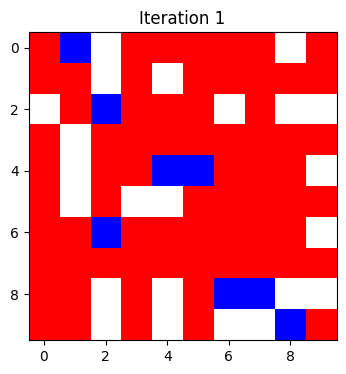

Iteration 2


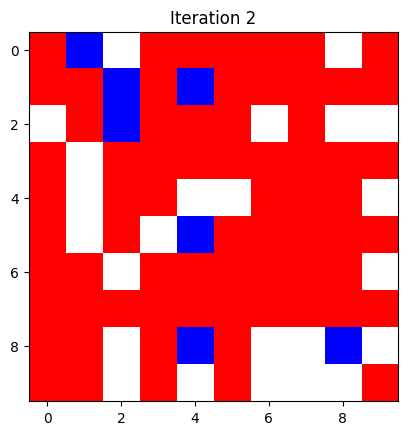

Iteration 3


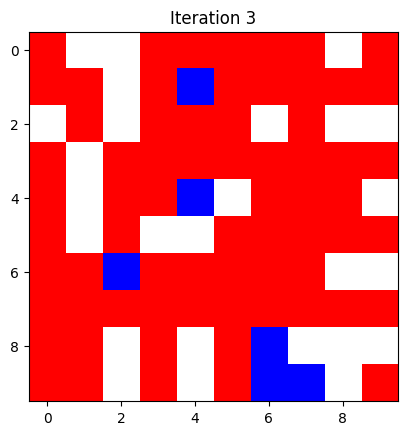

Iteration 4


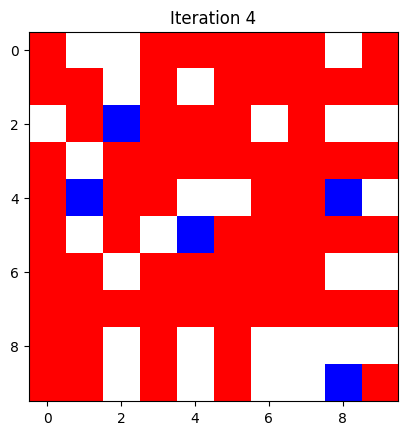

Iteration 5


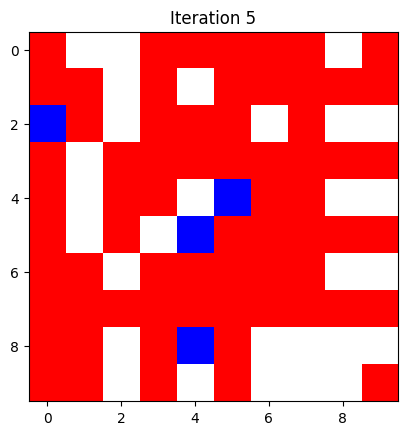

Iteration 6


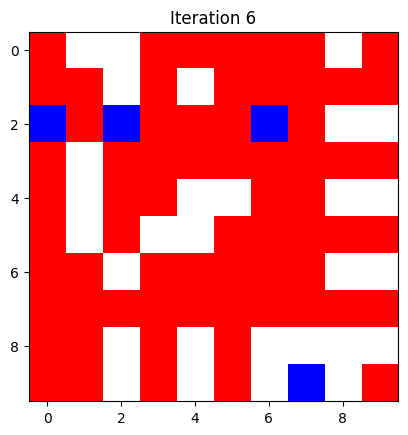

Iteration 7


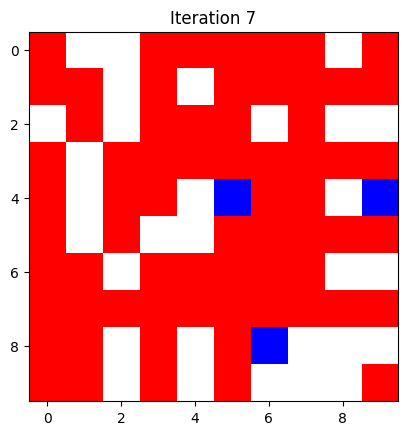

Iteration 8


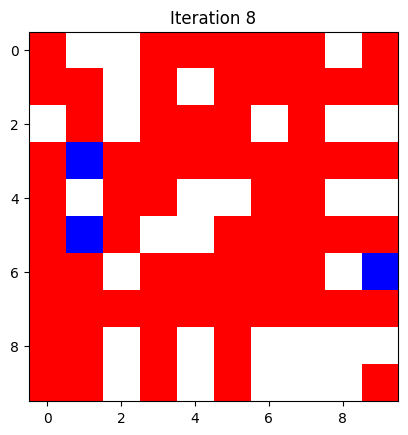

Iteration 9


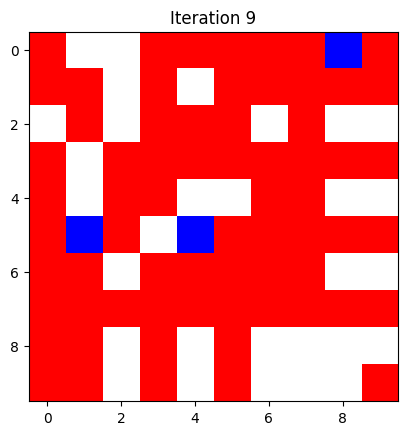

Iteration 10


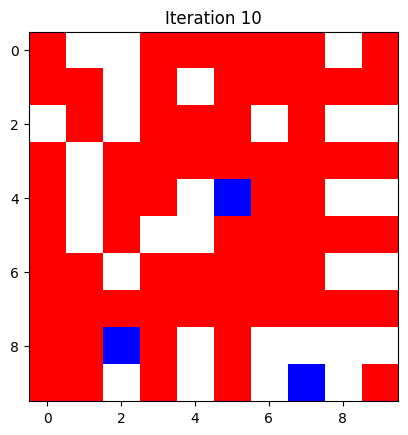

Iteration 11


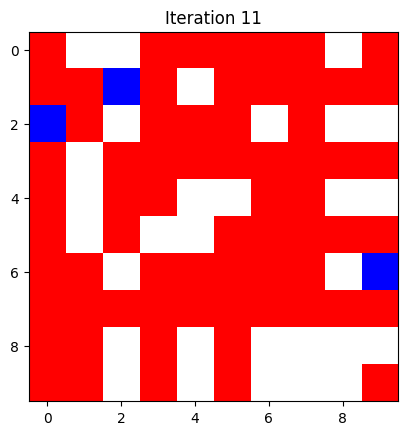

Iteration 12


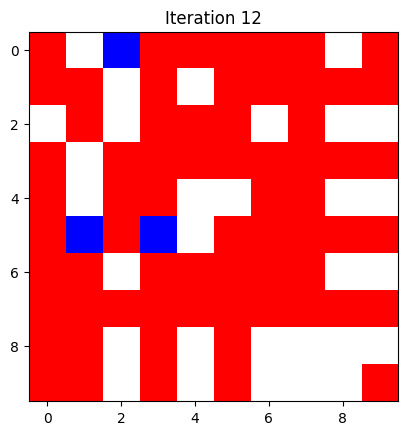

Iteration 13


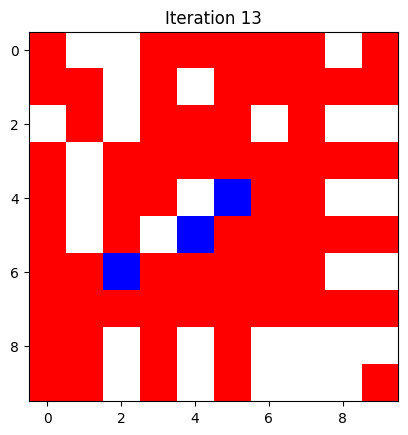

Iteration 14


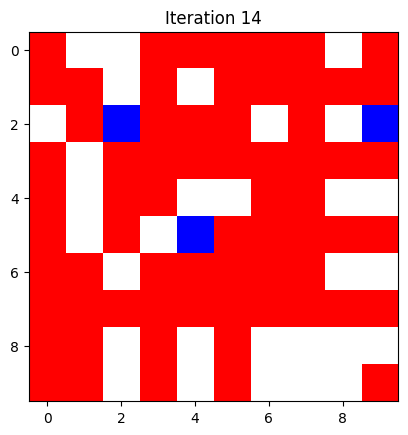

Iteration 15


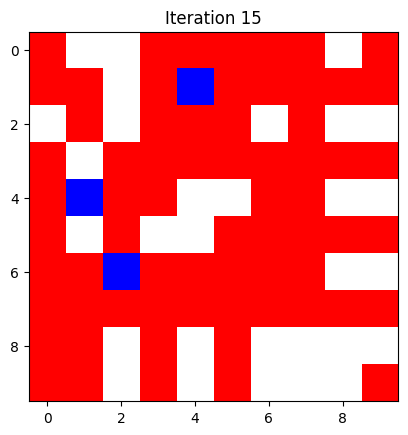

Iteration 16


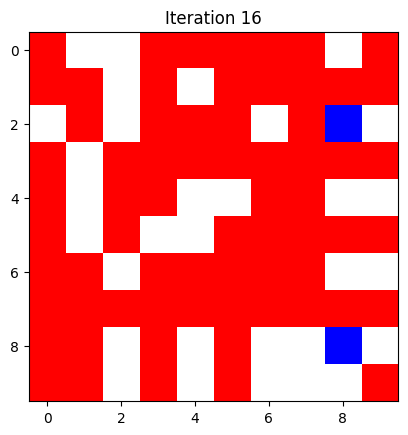

Iteration 17


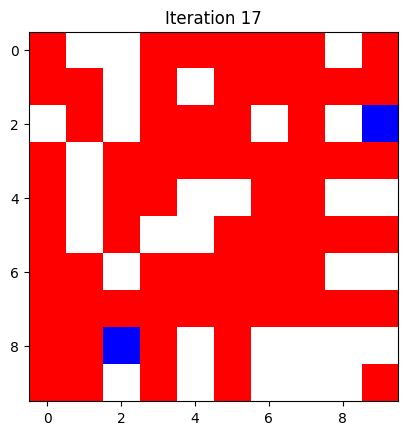

Iteration 18


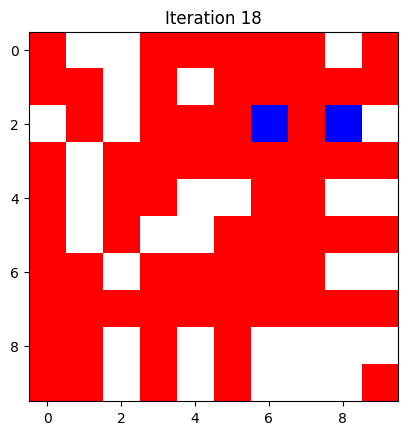

Iteration 19


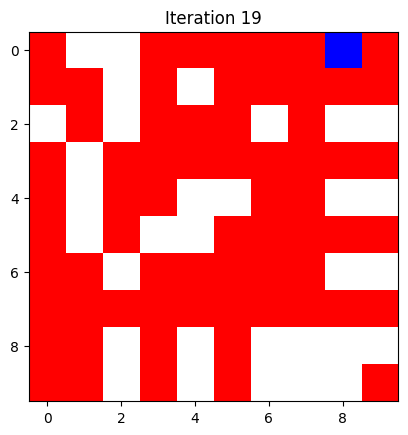

Iteration 20


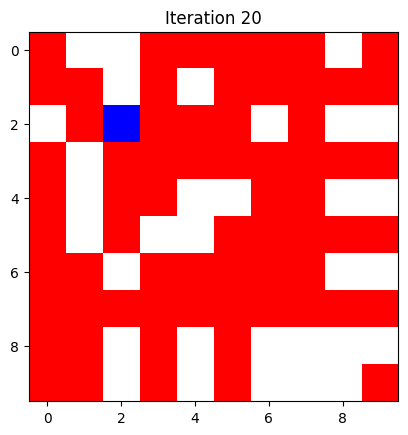

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import minimize

class SchellingModel:
    def __init__(self, grid_size, similarity_threshold, max_iterations, strategist_population_percentage):
        self.grid_size = grid_size
        self.similarity_threshold = similarity_threshold
        self.max_iterations = max_iterations
        self.strategist_population_percentage = strategist_population_percentage

        self.grid = np.zeros((grid_size, grid_size))
        self.agent_positions = []

    def initialize_agents(self, num_agents):
        vacant_spots = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]
        np.random.shuffle(vacant_spots)

        num_strategists = int(num_agents * self.strategist_population_percentage)
        num_schelling = num_agents - num_strategists

        for _ in range(num_strategists):
            position = vacant_spots.pop()
            self.grid[position[0], position[1]] = 1
            self.agent_positions.append(position)

        for _ in range(num_schelling):
            position = vacant_spots.pop()
            self.grid[position[0], position[1]] = 2
            self.agent_positions.append(position)

    def calculate_similarity(self, agent_position):
        x, y = agent_position
        agent_type = self.grid[x, y]
        similar_neighbors = 0
        total_neighbors = 0

        for i in range(max(0, x - 1), min(self.grid_size, x + 2)):
            for j in range(max(0, y - 1), min(self.grid_size, y + 2)):
                if self.grid[i, j] != 0:
                    total_neighbors += 1
                    if self.grid[i, j] == agent_type:
                        similar_neighbors += 1

        return similar_neighbors / total_neighbors if total_neighbors > 0 else 0

    def calculate_connectivity_change(self, agent_position, new_position):

        # The goal is to maximize this connectivity change
        # The connectivity change can be computed as the difference in similarity before and after the relocation
        # If the similarity increases, it's a positive change; otherwise, it's a negative change
        similarity_before = self.calculate_similarity(agent_position)
        similarity_after = self.calculate_similarity(new_position)
        return similarity_after - similarity_before

    def cost_function(self, new_position, agent_position):

        # The cost function can then be defined as the negative of the connectivity change, so that we can maximize it using optimization techniques
        return -self.calculate_connectivity_change((int(agent_position[0]),int(agent_position[1])), (int(new_position[0]),int(new_position[1])))

    def run_simulation(self):
        plt.figure(figsize=(4,4))
        cmap = mcolors.ListedColormap(['white', 'blue', 'red'])
        bounds = [0, 1, 2, 3]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

        for iteration in range(self.max_iterations):
            print(f"Iteration {iteration + 1}")

            np.random.shuffle(self.agent_positions)

            for agent_position in self.agent_positions:
                if self.grid[agent_position[0], agent_position[1]] == 1:  # Only for strategists
                    vacant_spots = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size) if self.grid[i, j] == 0]
                    if vacant_spots:
                        result = minimize(
                            self.cost_function,
                            x0=vacant_spots[np.random.randint(len(vacant_spots))],
                            args=(agent_position,),
                            bounds=[(0, self.grid_size-1), (0, self.grid_size-1)]
                        )
                        new_position = tuple(map(int, result.x))
                        self.grid[new_position[0], new_position[1]] = 1
                        self.grid[agent_position[0], agent_position[1]] = 0
                        self.agent_positions.remove(agent_position)
                        self.agent_positions.append(new_position)

            plt.imshow(self.grid, cmap=cmap, norm=norm)
            plt.title(f"Iteration {iteration + 1}")
            plt.show()


if __name__ == "__main__":
    grid_size = 10
    similarity_threshold = 0.3
    max_iterations = 20
    strategist_population_percentage = 0.1

    model = SchellingModel(grid_size, similarity_threshold, max_iterations, strategist_population_percentage)
    model.initialize_agents(num_agents=80)
    model.run_simulation()

No overlap and const function depends on neighborhood convolution differences. Also wrap-around effect of the grid, simulating it as if it were a continuous object.

In [ ]:
from networkx.algorithms.assortativity import connectivity
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import minimize

class SchellingModel:
    def __init__(self, grid_size, similarity_threshold, max_iterations, strategist_population_percentage):
        self.grid_size = grid_size
        self.similarity_threshold = similarity_threshold
        self.max_iterations = max_iterations
        self.strategist_population_percentage = strategist_population_percentage

        self.grid = np.zeros((self.grid_size, self.grid_size))
        self.grid[self.grid == 0] = 3
        self.agent_positions = []

        self.kernel = np.array([[1, 1, 1],
                                [1, 0, 1],
                                [1, 1, 1]], dtype=np.int8)

    def initialize_agents(self, num_agents):
        vacant_spots = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size) if self.grid[i, j] == 3]
        np.random.shuffle(vacant_spots)

        num_strategists = int(num_agents * self.strategist_population_percentage)
        num_schelling = num_agents - num_strategists

        for _ in range(num_strategists):
            position = vacant_spots.pop()
            self.grid[position[0], position[1]] = 1
            self.agent_positions.append(position)

        for _ in range(num_schelling):
            position = vacant_spots.pop()
            self.grid[position[0], position[1]] = 2
            self.agent_positions.append(position)

        plt.figure(figsize=(4,4))
        cmap = mcolors.ListedColormap(['red', 'grey', 'white'])
        col_bounds = [1, 2, 3, 4]
        norm = mcolors.BoundaryNorm(col_bounds, cmap.N)
        plt.imshow(self.grid, cmap=cmap, norm=norm)
        plt.show()
        plt.close()

    def get_wrapped_idx(self, idx):
        return idx % self.grid_size

    def wrapped_neighborhood(self, agent_position):
        x, y = agent_position
        neighborhood_indices = [
            (self.get_wrapped_idx(x - 1), self.get_wrapped_idx(y - 1)),
            (self.get_wrapped_idx(x - 1), self.get_wrapped_idx(y)),
            (self.get_wrapped_idx(x - 1), self.get_wrapped_idx(y + 1)),
            (self.get_wrapped_idx(x), self.get_wrapped_idx(y - 1)),
            agent_position,
            (self.get_wrapped_idx(x), self.get_wrapped_idx(y + 1)),
            (self.get_wrapped_idx(x + 1), self.get_wrapped_idx(y - 1)),
            (self.get_wrapped_idx(x + 1), self.get_wrapped_idx(y)),
            (self.get_wrapped_idx(x + 1), self.get_wrapped_idx(y + 1))
        ]

        return neighborhood_indices

    def calculate_similarity(self, agent_position):

        neighborhood_indices = self.wrapped_neighborhood(agent_position)

        neighborhood = self.grid[[int(i) for i, j in neighborhood_indices],
                                 [int(j) for i, j in neighborhood_indices]].reshape(3, 3)

        same_neigh = (neighborhood == 2)*self.kernel
        total_neigh = (neighborhood != 3)*self.kernel
        similarity_ratio = same_neigh.sum() / total_neigh.sum() if total_neigh.sum()>0 else 0

        return similarity_ratio

    def cost_function(self, new_position, agent_position):

        old_neighborhood_indices = self.wrapped_neighborhood(agent_position)
        new_neighborhood_indices = self.wrapped_neighborhood(new_position)

        old_neighborhood = self.grid[[int(i) for i, j in old_neighborhood_indices],
                                     [int(j) for i, j in old_neighborhood_indices]].reshape(3, 3)
        new_neighborhood = self.grid[[int(i) for i, j in new_neighborhood_indices],
                                     [int(j) for i, j in new_neighborhood_indices]].reshape(3, 3)

        diff_strat = np.abs(((old_neighborhood == 1)*self.kernel).sum() - ((new_neighborhood == 1)*self.kernel).sum())
        diff_nonstrat = np.abs(((old_neighborhood == 2)*self.kernel).sum() - ((new_neighborhood == 2)*self.kernel).sum())
        diff_vacant = np.abs(((old_neighborhood == 3)*self.kernel).sum() - ((new_neighborhood == 3)*self.kernel).sum())

        connectivity_difference = diff_strat + diff_nonstrat + diff_vacant

        return - (connectivity_difference)

    def run_simulation(self):
        plt.figure(figsize=(4,4))
        cmap = mcolors.ListedColormap(['red', 'grey', 'white'])
        col_bounds = [1, 2, 3, 4]
        norm = mcolors.BoundaryNorm(col_bounds, cmap.N)

        new_agent_positions = {}

        for iteration in range(self.max_iterations):
            print(f"Iteration {iteration + 1}")

            np.random.shuffle(self.agent_positions)

            new_agent_positions = set()
            vacant_spots = {(i, j) for i in range(self.grid_size) for j in range(self.grid_size) if self.grid[i, j] == 3}

            for agent_position in self.agent_positions:
              
                vacant_spots = {(i, j) for i in range(self.grid_size) for j in range(self.grid_size) if self.grid[i, j] == 3}
                if agent_position not in vacant_spots:

                  new_agent_positions.add(agent_position)

                  if self.grid[agent_position[0], agent_position[1]] == 1:  # Strategists

                      result = minimize(
                          self.cost_function,
                          x0=list(vacant_spots)[np.random.choice(len(vacant_spots))],
                          args=(agent_position,),
                          bounds=[(0, self.grid_size), (0, self.grid_size)]
                      )
                      new_position = tuple(map(int, result.x))
                      self.grid[new_position[0], new_position[1]] = 1     # move strategist to new position
                      self.grid[agent_position[0], agent_position[1]] = 3 # vacate the old position

                      new_agent_positions.add(new_position)
                      new_agent_positions.remove(agent_position)

                      vacant_spots.add(agent_position)
                      vacant_spots.remove(new_position)


                  elif self.grid[agent_position[0], agent_position[1]] == 2: # Non-strategists

                      similarity = self.calculate_similarity(agent_position)

                      if similarity < self.similarity_threshold:
                        print(similarity, "<", self.similarity_threshold, agent_position)

                        new_position = list(vacant_spots)[np.random.choice(len(vacant_spots))]
                        self.grid[new_position[0], new_position[1]] = 2       # move non-strategist to new position
                        self.grid[agent_position[0], agent_position[1]] = 3   # vacate old position

                        new_agent_positions.add(new_position)
                        new_agent_positions.remove(agent_position)

                        vacant_spots.add(agent_position)
                        vacant_spots.remove(new_position)

            self.agent_positions = list(new_agent_positions)

            plt.imshow(self.grid, cmap=cmap, norm=norm)
            plt.title(f"Iteration {iteration + 1}")
            plt.show()


if __name__ == "__main__":
    grid_size = 10
    similarity_threshold = 0.5
    max_iterations = 200
    strategist_population_percentage = 0.2

    model = SchellingModel(grid_size, similarity_threshold, max_iterations, strategist_population_percentage)
    model.initialize_agents(num_agents=50)
    model.run_simulation()